In [1]:
import sys, pickle
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, sys, os
import pandas as pd, seaborn as sns, argparse, pyemma
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../hde/')
sys.path.append('../')
from temp_tf_load import *
from hde import HDE, analysis

from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=False)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


In [2]:
# get temp and n slow modes determined by cross-val
srv_params = {'AT-all': [309, 5],
              'GC-end': [317, 5],
              'GC-core': [324, 3],
              'GC-mix': [324, 2]}

### Compute inter and intramolecular distances at each frame

In [ ]:
## generate all possible unique atoms pairs (intramolecular and intermolecular)

## Base IDs
## A = 135 = 3, 7, 11
## T = 126 = 4, 8, 12
## G = 151 = 5, 9, 13
## C = 110 = 6, 10, 14

#number of base pairs on each strand
num_bp = 10       

num_features = num_bp * (num_bp * 2 - 1)
num_intra = int((num_bp / 2) * (num_bp - 1))
atom_pairs = np.zeros((num_features, 2))
cnt = 0

##First strand bases ordered by atom id (minus 1 for python indexing)
base_id_a = [(i*3 + 2) - 1 for i in range(num_bp)]

##Second strand bases ordered by atom id (minus 1 for python indexing)
base_id_b = [(i*3 + num_bp*3 + 1) - 1 for i in range(num_bp)]

##generate all intermolecular combinations
for a in base_id_a:
    for b in base_id_b:
        atom_pairs[cnt, :] = [a, b]
        cnt += 1

##generate all intramolecular combos
for i in range(len(base_id_a)):
    for j in range(i):
        atom_pairs[cnt, :] = [base_id_a[i], base_id_a[j]]
        atom_pairs[cnt + num_intra, :] = [base_id_b[i], base_id_b[j]]
        cnt += 1

In [ ]:
# compute and save distances for equilibrium simulations

seq_list = ['AT-all', 'GC-core', 'GC-end', 'GC-mix']

for seq in  seq_list:

    temp = temp_dict[seq]
    traj_names = glob.glob(f'../Tjumps/{seq}*{temp}*{suffix}')
    top = f'../../seq_implicit_fix/{seq}/in00_cvmd.psf'

    dist_list = []

    for name in sorted(traj_names):

        # generate traj object and extract distances
        traj = name+traj_file
        traj_obj = mdtraj.load_lammpstrj(traj, top=top, unit_set='real')
        dist_arr = mdtraj.compute_distances(traj_obj, atom_pairs[diag_idx], periodic=True, opt=True)
        dist_list.append(dist_arr)
        #print(np.shape(dist_list))

    ## save all dist as array
    shp = str(np.shape(dist_list))[1:-1].replace(', ', '-')
    save_name = f'{save_dir}{seq}_T-{temp}_{shp}.npy'
    np.save(save_name, np.array(dist_list))


### Load and pre-process distance data -- these are our "features"

In [3]:
# specify sequence and parameters

seq = 'AT-all'
[temp, n_sm] = srv_params[seq]

# select Markovian alag time
lag_time = 12   # x 100 ps save rate = 1.2 ns

# load inverse distances
npy_name = f'../dna_data/{seq}_dist_reduced_{temp}K_40-250000-55.npy'
data = 1 / np.load(npy_name)
n_feat = data.shape[-1]

# scales all features to the range 0 and 1
scaler = pre.MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.concatenate(data))
pwd_features_s = [scaler.transform(item) for item in data]
print(np.shape(pwd_features_s))

# delete to save disk space
del data

(40, 250000, 55)


### Train sequence-specific SRVs using these features

In [24]:
# specify some SRV hyperparameters

k_folds = 5
n_epochs = 20
val_split = 0.2
batch_size = 50000
reversible = True
l_rate = 1e-3
hist_list = []

for d_i in range(k_folds): #range(len(pwd_features_s)):
    
    # split data into training and validations sets
    data_train, data_test = train_test_split(pwd_features_s, test_size=val_split)
    print(np.shape(data_train), np.shape(data_test))

    # intantiate hde object
    hde = HDE(n_feat, n_components=n_sm, lag_time=lag_time, dropout_rate=0, batch_size=batch_size, 
              n_epochs=n_epochs, validation_split=0, batch_normalization=True, learning_rate = l_rate, 
              reversible=reversible, verbose=1)
              #callbacks=[earlyStopping])

    # format data for fitting
    hde.r_degree = 2
    hde.n_epochs = n_epochs 

    # minimize data usage so as not to crash kernel
    hde.fit(data_train[0], y=data_test[0])
    #hde.fit(data_train, y=data_test)
    #hde.fit(pwd_features_s, y=pwd_features_s[0])
    
    #set callbacks to None and save compact hde
    history = hde.history
    hist_list.append(history)
    hde.callbacks = None
    hde.history = None
    
    prefix_k = f'sm-{n_sm}_k-{d_i}_lag-{lag_time}_ep-{n_epochs}_'
    pkl_hde_path = './srv_out/' + prefix_k + npy_name.split('/')[-1].replace('.npy', '.pkl')
    #pickle.dump(hde, open(pkl_hde_path, 'wb'), protocol=4)

(32, 250000, 55) (8, 250000, 55)
Train on 249988 samples, validate on 249988 samples
Epoch 1/20
249988/249988 [==============================] - 5s 19us/step - loss: -3.2813 - val_loss: -2.1122
Epoch 2/20
249988/249988 [==============================] - 1s 4us/step - loss: -4.3050 - val_loss: -2.1331
Epoch 3/20
249988/249988 [==============================] - 1s 5us/step - loss: -4.6109 - val_loss: -2.1533
Epoch 4/20
249988/249988 [==============================] - 1s 5us/step - loss: -4.7316 - val_loss: -2.1771
Epoch 5/20
249988/249988 [==============================] - 1s 5us/step - loss: -4.8093 - val_loss: -2.1980
Epoch 6/20
249988/249988 [==============================] - 1s 5us/step - loss: -4.8664 - val_loss: -2.2139
Epoch 7/20
249988/249988 [==============================] - 1s 5us/step - loss: -4.9078 - val_loss: -2.2195
Epoch 8/20
249988/249988 [==============================] - 1s 5us/step - loss: -4.9376 - val_loss: -2.2279
Epoch 9/20
249988/249988 [========================

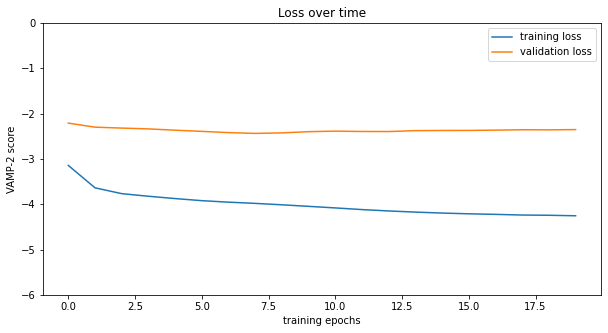

In [31]:
plt.figure(figsize=(10, 5))
history = hist_list[2]
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title('Loss over time')
plt.xlabel('training epochs')
plt.ylabel('VAMP-2 score')
plt.ylim(-6, 0)
plt.legend()


### Specify some MSM hyperparameters

In [3]:
srv_params = {'AT-all': [309, 5, 6],
              'GC-end': [317, 5, 6],
              'GC-core': [324, 3, 3],
              'GC-mix': [324, 2, 2]}

seq = 'AT-all' 
[temp, hde_nsm, nMacroStates] = srv_params[seq]

# lag times
lag = 12
srv_lag = 12
srv_ep = 20

# number of cluster centers and clustering stride
nClusterCentres = 200
stride = 1000

# specify if all steps need to be rerun
reduced = True
already_saved = True

# load traj data and hde path
load_path = '/home/mikejones/scratch-midway2/srv/implicit/'

if reduced:
    npy_equ =   f'dna_data/{seq}_dist_reduced_{temp}K_40-250000-55.npy'
    data = 1 / np.load(load_path+npy_equ)
else:
    npy_equ =   f'dna_data/{seq}_dist_{temp}K_40-250000-190.npy'
    data = 1 / np.load(load_path+npy_equ)[:, :, :100]
    
hde_name =  f"srv_out/sm-{hde_nsm}_k-0_lag-{srv_lag}_ep-{srv_ep}_{seq}{npy_equ.split(seq)[-1].replace('npy', 'pkl')}"

# create a directory to aggregate msm data
save_dir = f"MSMs/{npy_equ.split('/')[-1].replace('.npy', '')}"
save_dir += f'_micro-{nClusterCentres}_macro-{nMacroStates}_lag-{lag}_srvlag-{srv_lag}/'

if not already_saved:
    subprocess.run(['mkdir', save_dir])
    subprocess.run(['cp', hde_name, save_dir+'hde.pkl'])

### Transform high-dimensional trajectories into low-dimension srv and tica trajectories

In [4]:
# scales all features to the range 0 and 1
scaler = pre.MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.concatenate(data))
data_s = [scaler.transform(item) for item in data]
print(np.shape(data_s))

# transform coordinates based on loaded srv
hde = pickle.load(open(load_path+hde_name, 'rb'))
hdeOutput = [hde.transform(x) for x in data_s] 
print(np.shape(hdeOutput))

# compare with tica, use same dimensions and lag as srv for consistency
tica = pyemma.coordinates.tica([traj for traj in data_s], lag=srv_lag, dim=hde_nsm)
ticaOutput = tica.get_output()
print(np.shape(ticaOutput))

(40, 250000, 55)



(40, 250000, 5)


(40, 250000, 5)


### plot joint/marginal distribtion of srv and tica coordinatess

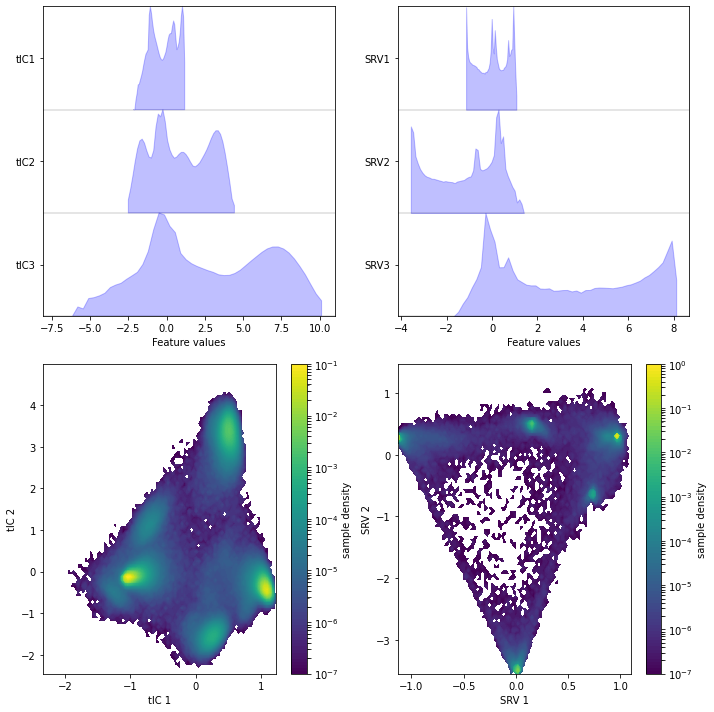

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ylog = True
n_comp = 3

pyemma.plots.plot_feature_histograms(
    np.concatenate(ticaOutput, axis=0)[:, :n_comp],
    ax=axes[0, 0],
    feature_labels=[f'tIC{i+1}' for i in range(n_comp)],
    ylog=ylog)

pyemma.plots.plot_feature_histograms(
    np.concatenate(hdeOutput, axis=0)[:, :n_comp],
    ax=axes[0, 1],
    feature_labels=[f'SRV{i+1}' for i in range(n_comp)],
    ylog=ylog)

# plot lowd free energy on both coordinates
ax = axes[1, 0]
pyemma.plots.plot_density(*np.concatenate(ticaOutput, axis=0)[:, :2].T, ax=ax, logscale=True)
ax.set_xlabel('tIC 1')
ax.set_ylabel('tIC 2')
fig.tight_layout()

ax=axes[1, 1]
pyemma.plots.plot_density(*np.concatenate(hdeOutput, axis=0)[:, :2].T, ax=ax, logscale=True)
ax.set_xlabel('SRV 1')
ax.set_ylabel('SRV 2')
fig.tight_layout()

In [6]:
%%time

# load intermediate clustering steps if already saved
if already_saved:
    cluster_hde = pickle.load(open(save_dir + 'hde_cluster.pkl', 'rb'))
    cluster_tica = pickle.load(open(save_dir + 'tica_cluster.pkl', 'rb'))

    dtraj_tica = cluster_tica.dtrajs
    dtraj_hde = cluster_hde.dtrajs

else:
    
    # cluster based on srv and tica dynamical representations
    cluster_hde = pyemma.coordinates.cluster_kmeans(hdeOutput, 
                        stride=stride, k=nClusterCentres, max_iter=50)

    cluster_tica = pyemma.coordinates.cluster_kmeans(ticaOutput, 
                        stride=stride, k=nClusterCentres, max_iter=50)

    # extract discrete trajectories along microstates found above
    dtraj_tica = cluster_tica.dtrajs
    dtraj_hde = cluster_hde.dtrajs

    #save cluster data
    cluster_hde_name = save_dir+f'hde_cluster.pkl'
    with open(cluster_hde_name, 'wb') as f:
        pickle.dump(cluster_hde, f)
    f.close()

    cluster_tica_name = save_dir+f'tica_cluster.pkl'
    with open(cluster_tica_name, 'wb') as f:
        pickle.dump(cluster_tica, f)
    f.close()

    #save cluster data
    dtraj_hde_name = save_dir+f'dtraj_hde.pkl'
    with open(dtraj_hde_name, 'wb') as f:
        pickle.dump(dtraj_hde, f)
    f.close()

    dtraj_tica_name = save_dir+f'dtraj_tica.pkl'
    with open(dtraj_tica_name, 'wb') as f:
        pickle.dump(dtraj_tica, f)
    f.close()

CPU times: user 69.8 ms, sys: 67.8 ms, total: 138 ms
Wall time: 895 ms


In [7]:
# find implied timescales according to these discrete clusters

nits, lags = 8, 50
its_tica = pyemma.msm.its(dtraj_tica, lags=lags, nits=nits) #errors='bayes')
its_hde = pyemma.msm.its(dtraj_hde, lags=lags, nits=nits)   #errors='bayes')


### Show improvement to implied timescale convergence with SRV compared to tICA

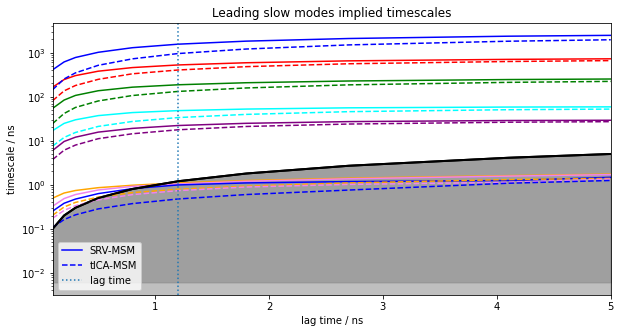

In [8]:
#plotting timescales

fig, ax = plt.subplots(1, figsize=(10, 5))
dt = 0.1

pyemma.plots.plot_implied_timescales(its_hde, units='ns', dt=dt, ax=ax, 
                                     linestyle='solid', label='SRV-MSM')
pyemma.plots.plot_implied_timescales(its_tica, units='ns', dt=dt, ax=ax, 
                                     linestyle='dashed', label='tICA-MSM')

#pyemma.plots.plot_implied_timescales(its_hde, units='ns', dt=dt, ax=ax[1], linestyle='solid', label='SRV')
#pyemma.plots.plot_implied_timescales(its_tica, units='ns', dt=dt, ax=ax[1], linestyle='dashed', label='TICA')

ax.set_title('Leading slow modes implied timescales')
#ax[1].set_title('Ignore Leading mode')

# plot lag intersection
ax.axvline(lag*dt, linestyle='dotted', label = 'lag time')

h, l = ax.get_legend_handles_labels()
h1, l1 = [h[0], h[nits], h[-1]], [l[0], l[nits], l[-1]]
ax.legend(h1, l1)

#ax[1].set_ylim(100, 2000)
#ax[1].set_xlim(0, 2000)


In [9]:
# build msms using choice of lag time

if already_saved:
    
    msm_hde = pickle.load(open(save_dir+'msm_hde.pkl', 'rb'))
    msm_tica = pickle.load(open(save_dir+'msm_tica.pkl', 'rb'))
    
    pcca_hde = msm_hde.pcca(nMacroStates)
    pcca_tica = msm_tica.pcca(nMacroStates)

else:

    # nMacroStates = 3
    # lag = 12

    msm_hde = pyemma.msm.bayesian_markov_model(dtraj_hde, lag)
    msm_tica = pyemma.msm.bayesian_markov_model(dtraj_tica, lag)

    # cluster each into nMacroStates macro clusters
    pcca_hde = msm_hde.pcca(nMacroStates)
    pcca_tica = msm_tica.pcca(nMacroStates)

    # save hde msm
    msm_hde_name = save_dir+f'msm_hde.pkl'
    with open(msm_hde_name, 'wb') as f:
        pickle.dump(msm_hde, f)
    f.close()

    # save tica msm
    msm_tica_name = save_dir+f'msm_tica.pkl'
    with open(msm_tica_name, 'wb') as f:
        pickle.dump(msm_tica, f)
    f.close()

### Stationary probabilities are more stable for SRVs than tICA

In [10]:
# calculate pcca probabilities and free energies 

print('msm-srv')
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm_hde.metastable_sets):
    p = msm_hde.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))
    
print('\nmsm-tica')
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm_tica.metastable_sets):
    p = msm_hde.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

msm-srv
state	π		G/kT
1	0.001176	6.745444
2	0.003555	5.639273
3	0.015254	4.182923
4	0.079042	2.537778
5	0.414777	0.880014
6	0.486195	0.721145

msm-tica
state	π		G/kT
1	0.003466	5.664858
2	0.107317	2.231969
3	0.040679	3.202052
4	0.098398	2.318739
5	0.400748	0.914424
6	0.349394	1.051556


### generate pcca coarse grained transition matrix

[[9.47257e-01 6.20000e-05 4.84900e-03 1.25000e-04 1.07000e-03 4.66360e-02]
 [2.60000e-05 9.75691e-01 1.52000e-04 5.23000e-03 5.11000e-04 1.83910e-02]
 [3.96000e-04 3.70000e-05 9.93644e-01 5.60000e-05 2.32600e-03 3.54100e-03]
 [2.00000e-06 2.35000e-04 1.10000e-05 9.97852e-01 8.87000e-04 1.01300e-03]
 [3.00000e-06 5.00000e-06 8.60000e-05 1.69000e-04 9.99479e-01 2.58000e-04]
 [1.22000e-04 1.37000e-04 1.12000e-04 1.65000e-04 2.20000e-04 9.99244e-01]]


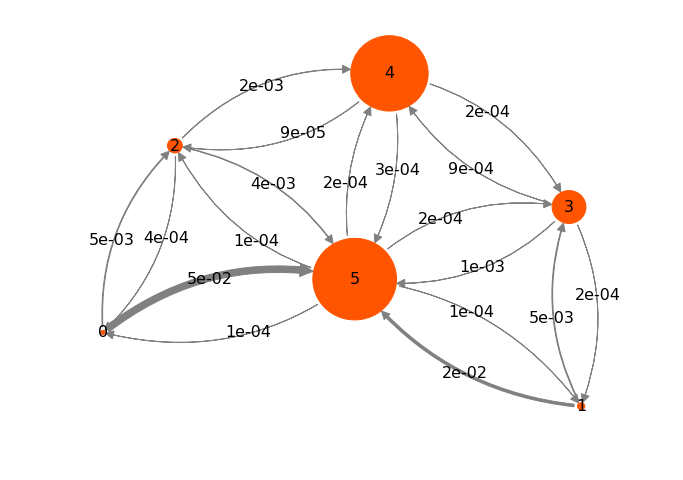

In [11]:
plt.rcParams.update({'font.size': 16})
T = pcca_hde.coarse_grained_transition_matrix.copy()
#T = pcca_tica.coarse_grained_transition_matrix.copy()

T[T < 0] *= 0
T = T/T.sum(axis=1)[:, np.newaxis]

print(np.round(T, 6))
fig, pos = pyemma.plots.plot_markov_model(T, minflux=5e-6, arrow_curvature=1.5)

# 8e-6 GC-end
# 5e-6 AT-all
# 5e-5 GC-core

(<Figure size 720x720 with 36 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='lag time (ns)', ylabel='probability'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='lag time (ns)'>,
         <AxesSubplot:xlabel='l

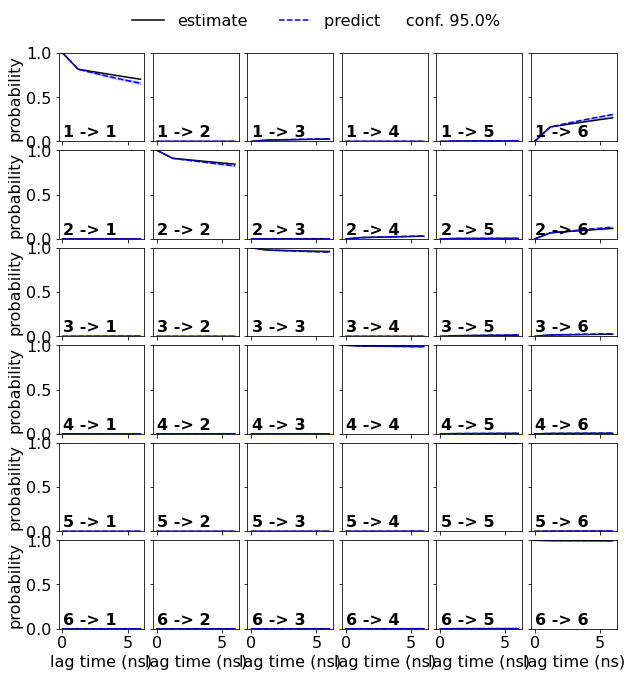

In [13]:
## ck test to compare fidelity of longterm predictions

nstates = 6  # choose based on knowledge of metastable sattes
cktest = msm_hde.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')

In [14]:
## make heatmaps showing all intermolecular distances across various slow modes
def make_heatmap(frame):

    plot_arr = np.zeros((10, 10))
    for pair in range(100):

        x = int(pair / 10)
        y = pair % 10
        plot_arr[x, y] = frame[pair]
        
    return plot_arr

data_c = np.concatenate(data)

check no assert
0 100
1 100
2 100
3 100
4 100
5 100


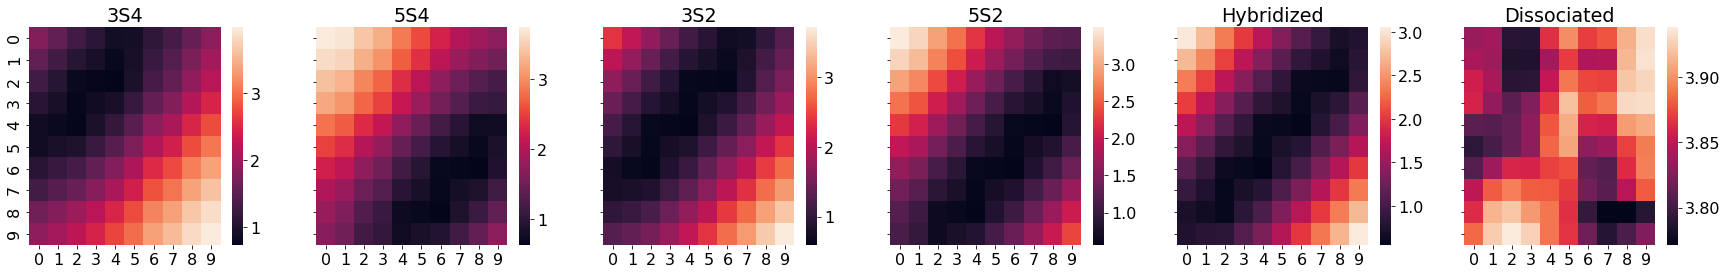

In [15]:
# heatmaps for msm pcca clustering

npy_full =   f'dna_data/{seq}_dist_{temp}K_40-250000-190.npy'
data_full = np.load(load_path+npy_full)[:, : ,:100]

n_frames = data_full.shape[1]
data_full = np.concatenate(data_full)
AT_all_state_list = ['3S4', '5S4', '3S2', '5S2', 'Hybridized', 'Dissociated']

n_samples = 100
msm = msm_tica #msm_hde
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, n_samples)
fig, axes = plt.subplots(1, len(pcca_samples), figsize=(len(pcca_samples)*5, 4), sharex=True, sharey=True)

for x_i, state in enumerate(pcca_samples):
                            
    ## contatenate indices from pcca_samples
    f_list = [f[0]*n_frames + f[1] for f in state]
    print(x_i, len(f_list))

    ## find mean distance values across all frames in f_list for given state
    state_avg = [np.mean(data_full[f_list][:, i]) for i in range(100)]
    
    ## plot heatmaps
    sns.heatmap(make_heatmap(state_avg), ax=axes[x_i])
    axes[x_i].set_title(AT_all_state_list[x_i])
    
    ## find mean distance values across all frames in f_list for given state
    #state_std = [np.std(data_full[f_list][:, i]) for i in range(100)]
    
    ## plot heatmaps showing standard deviation in coordinates
    #sns.heatmap(make_heatmap(state_std), ax=axes[1, x_i])


(600.0, 1000.0)

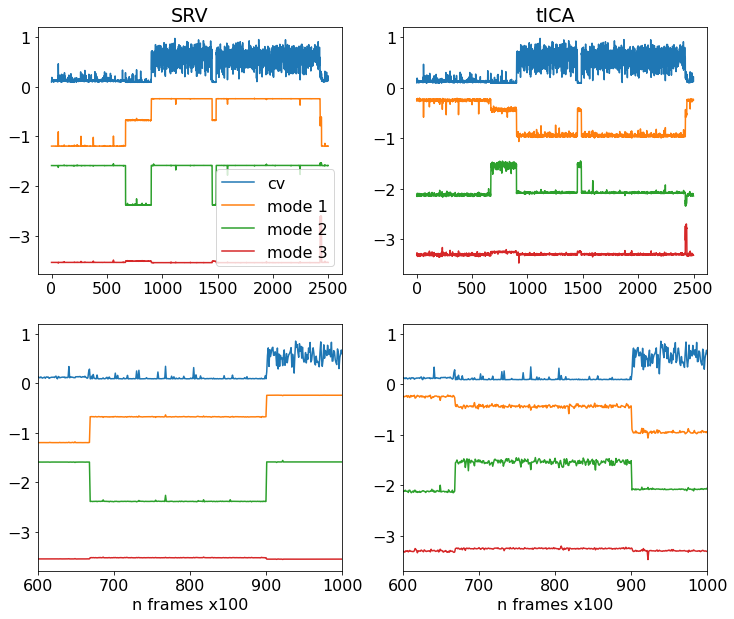

In [16]:
## track modes with distance

p_stride = 100  # stride for plottin 
traj_idx = 38    # which traj to look at
cv = 29         # measure a specific distance
n_modes = 3     # number of modes to compare
zoom_region = (600, 1000)   # take closer look with visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# look at one traj
data_traj = data_full[traj_idx*n_frames:(traj_idx+1)*n_frames]
hde_traj = hdeOutput[traj_idx]
tica_traj = ticaOutput[traj_idx]

# plot relevant distance metric (or cv)
dist = data_traj[:, cv]
for ax in axes.flatten():
    ax.plot(dist[::p_stride]/np.max(dist), label=f'cv')

for i in range(n_modes):
    
    # plot normalized hde
    floor = np.min(hde_traj[:, i])
    norm = np.max(hde_traj[:, i]) - floor
    axes[0, 0].plot((hde_traj[::p_stride, i]-floor)/norm - 1.2*(i+1), label=f'mode {i+1}')
    axes[1, 0].plot((hde_traj[::p_stride, i]-floor)/norm - 1.2*(i+1), label=f'mode {i+1}')
    
    # plot normalized tica
    floor = np.min(tica_traj[:, i])
    norm = np.max(tica_traj[:, i]) - floor
    axes[0, 1].plot((tica_traj[::p_stride, i]-floor)/norm - 1.2*(i+1), label=f'mode {i+1}')
    axes[1, 1].plot((tica_traj[::p_stride, i]-floor)/norm - 1.2*(i+1), label=f'mode {i+1}')
    
axes[0, 0].legend()
axes[0, 0].set_title('SRV')
axes[0, 1].set_title('tICA')
axes[1, 0].set_xlabel('n frames x100')
axes[1, 1].set_xlabel('n frames x100')
axes[1, 0].set_xlim(zoom_region)
axes[1, 1].set_xlim(zoom_region)

In [17]:
### view specific traj

import nglview as nv
import mdtraj as md
import glob

In [18]:
seq = 'AT-all'
lmps_dir = '../dna_data/'
psf_path = glob.glob(f'{lmps_dir}3spn2_topologies/{seq}/*.psf')[0]
psf_all_ade = glob.glob(f'{lmps_dir}3spn2_topologies/{seq}/*test.psf')[0]
traj_files = sorted(glob.glob(f'{lmps_dir}equ_final_trajs/{seq}*s-13e+09/*.lammpstrj'))

print(psf_path)
print(traj_files[0])

../dna_data/3spn2_topologies/AT-all/in00_cvmd.psf
../dna_data/equ_final_trajs/AT-all-implicit-dis-0-0_T-309_t-20_s-13e+09/traj.lammpstrj


In [19]:
# load mdtraj object
#traj = md.load(traj_files[-1], top=psf_path)
traj = md.load(traj_files[traj_idx], top=psf_all_ade)


In [20]:
print(len(traj))

center = 670   # based coarse plot above
size = 1000
skip = 10000
      
start = skip + center*p_stride - size//2
end = start + size

view = nv.show_mdtraj(traj[start:end])
view.add_ball_and_stick()  # almost works
#view.add_licorice('DNA1, DNA2') # almost works
#view.add_cartoon(selection="DNA1, DNA2", color='blue')
#view.update_cartoon(opacity=0.4, component=1)
#view.add_surface(selection="DNA1, DNA2", opacity=0.5, color='blue') # closest thing to working!
#view.add_surface(selection="DNA1, DNA2", opacity=0.5, color='blue')

view

260001


NGLWidget(max_frame=999)